In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# first code up the lisle process from any initial conditions
def walkit(k0=1.0,k1=1.0,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    """
    k0 is the inverse mean resting time
    k1 is the inverse mean moving time
    v is the velocity
    tmax is the maximum time to walk
    theta0 is the probability of starting at rest
    theta1 is the probability of starting in motion
    """
    S = []
    T = []
    s = int(np.random.random() > theta0) # initial state
    t = 0.0 # initial time
    T.append(t)
    S.append(s)
    i0 = 0
    i1 = 0
    # generate random values once.. be sure there's enough
    while True:
        psi0 = np.random.exponential(1/k0,size=5*round(tmax*k0))
        if psi0.cumsum().max()>tmax:
            break
    while True:
        psi1 = np.random.exponential(1/k1,size=5*round(tmax*k1))
        if psi1.cumsum().max()>tmax:
            break
    # it's much faster to generate too many. 
    np.random.exponential(k1)
    while t<tmax:
        if s==0:
            t = t + psi0[i0]
            i0+=1
            s = 1 
            T.append(t)
            S.append(s)
        elif s==1:
            t = t + psi1[i1]
            i1+=1
            s = 0
            T.append(t)
            S.append(s)
    return np.array(T),np.array(S)

def plotit(walk):
    t,s = walk
    widths = np.diff(t)
    plt.bar(t[:-1],s[:-1]+1,width=widths,edgecolor='black',facecolor='purple',align='edge',zorder=-1)
    
def dispit(walk,ts,v=1.0):
    t,xs = walk
    i = np.searchsorted(t,ts)
    xs = xs[i]
    dt = ts[1]-ts[0]
    xs = (xs*v*dt).cumsum()
    return xs

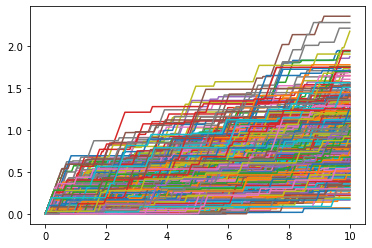

In [15]:
for i in range(500):
    walk = walkit(k0=10,tmax=1000)
    tm = walk[0].max()
    ts = np.arange(0,10,1e-3)
    xs = dispit(walk,ts)
    plt.plot(ts,xs)

In [4]:
def ensit(n=10,k0=1.0,k1=1.0,dt=1e-1,v=1.0,tmax=10,theta0=0.5,theta1=0.5):
    T = np.arange(0,tmax,dt)
    X = []
    for i in range(n):
        walk = walkit(k0=k0,k1=k1,v=v,tmax=tmax,theta0=theta0,theta1=theta1)
        x = dispit(walk,T,v=v)
        X.append(x)
    X = np.array(X)
    return T,X

def statsit(ensemble):
    T,X = ensemble
    var = X.var(0)
    mean = X.mean(0)
    return T,mean,var

In [ ]:
ts0,mean0,var0 = statsit(ensit(n=1000,tmax=1000,dt=1e-3,theta0=1,theta1=0,k0=0.1,k1=1))
plt.loglog(ts0,var0,label='initially at rest')
ts1,mean1,var1 = statsit(ensit(n=1000,tmax=1000,dt=1e-3,theta0=0,theta1=1,k0=0.1,k1=1))
plt.loglog(ts1,var1,label='initially in motion')
plt.legend()
plt.xlim(1e-3,5e3)
plt.ylim(1e-6,1e4)

t0 = np.geomspace(1e-3,1,100)
plt.loglog(t0,t0**3,color='black')
t1 = np.geomspace(1e1,1e3,100)
plt.loglog(t1,t1,color='black')